# Capstone Project: Predict Amazon Book Review Ratings Using  Sentiment Analysis

## Modeling


_By: Jin Park_

---
### Objectives

- Create different models to identify the best performing model. 
- Use RandomForest Classifier to predict rating by using text and summary review polarity and subjectivity as features.
- Use Logistic Regression to predict rating by using text and summary review polarity and subjectivity as features.
- Use Keras Neural Network to predict rating by using text and summary review polarity and subjectivity as features.

---
### Project Guide (Modeling)
- [Imports](#Imports)
- [Modeling](#Modeling)
    - [Baseline](#Baseline)
    - [RandomForest Classifier](#RandomForest Classifier)
        - [Randomized Searched Params](#Randomized Searched Params)
        - [RandomizedSearch RandomForest Classifier](#RandomizedSearch RandomForest Classifier)
        - [Grid-Search RandomizedSearch RandomForest Classifier](#Grid-Search RandomizedSearch RandomForest Classifier)
    - [Logistic Regression](#Logistic Regression)
        - [Logistic Regression Randomized Searched Params](#Logistic Regression Randomized Searched Params)
    - [Keras Neural Network](#Keras Neural Network)
        - [Train and Test Loss](#Train and Test Loss)
        - [Accuracy](#Accuracy)
    - [Can Text Data Have Better Prediction?](#Can Text Data Have Better Prediction?) 

<a id='Imports'></a>
# Imports

In [1]:
import time
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from pprint import pprint
from collections import Counter
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,LabelEncoder

import tensorflow as tf
import keras

from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.utils import to_categorical, np_utils

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
# Load modeling data
amazon = pd.read_csv('data/amazon_sample_modeling.csv')
amazon.head()

,review_date,reviewer_id,reviewer_name,book_category,review_text,review_summary,rating,helpful_review,summary_pol,summary_subj,text_pol,text_subj
0,2006-01-18,A3SHA4Y9DHEK39,Chad Oberholtzer,Christian Books & Bibles,live church culture holiness rarely mentioned ...,great one,5,0,0.8,0.8,0.3,0.5
1,2008-03-16,A11M98R135HMSY,Paul Skinner,"Mystery, Thriller & Suspense",philip craigs finally got around first j w jac...,begining beautiful relationship,5,1,0.8,1.0,0.2,0.5
2,2013-02-26,AD20B29YQDZYQ,Amazon Customer,Literature & Fiction,storyline good reason finished filled way much...,ok,2,1,0.5,0.5,0.1,0.5
3,2013-07-16,AZR6CYHTQ9TL,Inez,Science Fiction & Fantasy,love apocalypse stories one really creeped lik...,oh bugs everywhere,5,1,0.0,0.0,0.4,0.4
4,2013-04-14,A14BTJRH9VNLJJ,Kurt A. Johnson,Biographies & Memoirs,sociopath sociopath person little conscience p...,interesting thought provoking,4,1,0.5,0.5,0.1,0.5


<a id='Modeling'></a>
# Modeling
The target is a multi-classification problem since the rating contains values from 1 to 5. However, it can be converted into binary classification by performing a boolean filtering. For example, if the rating is greater than or equal 3 then convert to 1 else 0 or create a label encoder by using sklearn.

 Based on the performance of the different models, modeling techniques will be adjusted to increase the scores. 

<a id='Baseline'></a>
### Baseline
Before modeling, it is best to know the baseline.  There are 5 different categories of the rating. Simply, a baseline can be calculated by getting the length of the most frequently occurring rating which is rating 5 and divide it by the overall length of rating. This will give the baseline result 55% to beat. 

In [3]:
# Setting the baseline to beat!
baseline = len(amazon[amazon['rating'] == 5])/len(amazon['rating'])
baseline

0.5460774237752655

<a id='RandomForest Classifier'></a>
## RandomForest Classifier
RandomForest Classifier generally takes a very long time to perform especially with Grid-search method which runs all tests and picks out the best performing model. This can be very exhaustive search. To avoid this problem, I have set a randomized searched parameters and the RandomizedSearchCV will randomly generate the parameters and use it for RandomForest Classifier to predict the rating by using sentiment analysis as for features. After doing the randomized searched RandomForest Classifier, use the best parameters of this RandomForest Classifier to perform a Grid-Search to optimize the model score. As a result, overall randomized search RandomForest classifier only outperforms the baseline by 1% and Grid-search performs less than the baseline.

<a id='Randomized Searched Params'></a>
### Randomized Searched Params

In [4]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 4, 8, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 19, 28, 37, 46, 55, 64, 73, 82, 91, 100, None],
 'max_features': ['auto', 'sqrt', 'log2'],
 'min_samples_leaf': [1, 2, 4, 8, 10],
 'min_samples_split': [2, 4, 8, 10],
 'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}


<a id='RandomizedSearch RandomForest Classifier'></a>
### RandomizedSearch RandomForest Classifier

In [25]:
%%time
X = amazon[['summary_pol', 'summary_subj','text_pol', 'text_subj']]
y = amazon['rating']

X_train, X_test, y_train, y_test = train_test_split(X,y)

le = LabelEncoder()
le.fit(y)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 100,
                               cv = 5,
                               verbose = 1,
                               random_state = 42,
                               n_jobs = 1)
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: user 1min 33s, sys: 357 ms, total: 1min 33s
Wall time: 1min 33s


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.6min finished


In [26]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 82,
 'max_features': 'sqrt',
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 20}

In [27]:
best_random = rf_random.best_estimator_
random_accuracy = best_random.score(X_test, y_test)
print('Baseline:', baseline)
print('RandomForest Classifier Score:', random_accuracy * 100)

Baseline: 0.5460774237752655
RandomForest Classifier Score: 55.525114155251146


<a id='Grid-Search RandomizedSearch RandomForest Classifier'></a>
### Grid-Search RandomizedSearch RandomForest Classifier

In [28]:
# Create the parameter grid based on the results of random search 
param_grid = {'bootstrap': [True],
              'max_depth': [82],
              'max_features': ['sqrt'],
              'min_samples_leaf': [10],
              'min_samples_split': [10],
              'n_estimators': [20]}

# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf,
                           param_grid = param_grid,
                           cv = 5,
                           n_jobs = 1,
                           verbose = 1)

In [29]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'bootstrap': True, 'max_depth': 82, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 20}


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished


In [30]:
best_grid = grid_search.best_estimator_
grid_accuracy = best_grid.score(X_test, y_test)
print('Baseline:', baseline)
print('Grid-Search RandomForest Classification Score:', grid_accuracy * 100)

Baseline: 0.5460774237752655
Grid-Search RandomForest Classification Score: 55.79908675799087


<a id='Logistic Regression Randomized Searched Params'></a>
## Logistic Regression Randomized Searched Params

In [19]:
penalty = ['l1', 'l2']
C = [float(x) for x in np.linspace(0.00001, 1.0, num = 11)]
max_iter = [int(x) for x in np.linspace(100, 10000, num = 10)]
class_weight = ['balanced']
    
# Create the random grid
lr_random_grid = {'penalty': penalty,
                  'C': C,
                  'max_iter': max_iter}

pprint(lr_random_grid)

{'C': [1e-05,
       0.100009,
       0.20000800000000002,
       0.300007,
       0.40000600000000003,
       0.500005,
       0.600004,
       0.700003,
       0.800002,
       0.9000009999999999,
       1.0],
 'max_iter': [100, 1200, 2300, 3400, 4500, 5600, 6700, 7800, 8900, 10000],
 'penalty': ['l1', 'l2']}


<a id='Logistic Regression'></a>
## Logistic Regression
For Logistic Regression, I have also set a randomized searched parameters and use the same processes with the RandomForest Classifier model. As a result, Logistic regression performs less than the baseline.

In [38]:
%%time
X = amazon[['text_pol', 'summary_pol','text_subj', 'summary_subj']]
y = amazon['rating']

X_train, X_test, y_train, y_test = train_test_split(X,y)

le = LabelEncoder()
le.fit(y)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

lr = LogisticRegression()
lr_random = RandomizedSearchCV(estimator = lr,
                               param_distributions = lr_random_grid,
                               n_iter = 100,
                               cv = 10,
                               verbose=1,
                               random_state=42,
                               n_jobs = 1)
lr_random.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
CPU times: user 2min 11s, sys: 956 ms, total: 2min 12s
Wall time: 33.2 s


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   33.2s finished


In [39]:
lr_random.best_params_

{'C': 0.100009, 'max_iter': 5600, 'penalty': 'l1'}

In [40]:
best_random = lr_random.best_estimator_
lr_random_score = best_random.score(X_test, y_test)
print('Random Logistic Regression Score:', lr_random_score * 100)

Random Logistic Regression Score: 54.69387755102041


In [27]:
# Create the parameter grid based on the results of random search 
param_grid = {'C': [0.100009], 'max_iter': [5600], 'penalty': ['l1']}

# Create a based model
lr = LogisticRegression()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = lr,
                           param_grid = param_grid,
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

In [28]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'C': 0.100009, 'max_iter': 5600, 'penalty': 'l1'}


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


In [29]:
best_grid = grid_search.best_estimator_
grid_accuracy = best_grid.score(X_test, y_test)
print('Grid-Search Logistic Regression Score:', grid_accuracy * 100)

Grid-Search Logistic Regression Score: 54.331065759637184


<a id='Keras Neural Network'></a>
## Keras Neural Network
I have set a label encoder to convert target variable into a binary classification problem. This neural network has 3 hidden layers with Relu activation function and random dropout by 50%. The output activation function uses softmax since its a classification problem. Then model complies by using binary cross-entropy as a loss function with Adam optimizer and accuracy metrics. Lastly, I have set an early stop function to prevent unnecessary training by running all epochs. As a result, this neural network is able to predict rating with 82% score on test set data.  

In [31]:
X = amazon[['text_pol', 'summary_pol','text_subj', 'summary_subj']]
y = amazon['rating']

X_train, X_test, y_train, y_test = train_test_split(X,y)

le = LabelEncoder()
le.fit(y)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

model = Sequential()

n_input = X_train.shape[1]
n_hidden = n_input
n_output = y_train.shape[1]

# 1st hidden layer
model.add(Dense(n_hidden,
                input_dim=n_input,
                activation='relu',
                kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dropout(0.5))
# 2nd hidden layer
model.add(Dense(n_hidden,
                activation='relu'))
model.add(Dropout(0.5))
# 3rd hidden layer
model.add(Dense(n_hidden,
                activation='relu'))
model.add(Dropout(0.5))
# Output
model.add(Dense(n_output,
                activation='softmax'))
# Model Compile
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# Early Stop
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0,
                           patience=0,
                           verbose=1,
                           mode='auto')

callbacks_list = [early_stop]

history = model.fit(X_train,
                    y_train, 
                    validation_data=(X_test, y_test),
                    epochs=50,
                    batch_size=None,
                    callbacks = callbacks_list,
                    verbose=1)

score = model.evaluate(X_test, y_test, batch_size=128)

Train on 6614 samples, validate on 2205 samples
Epoch 1/50
6614/6614 [==============================] - 1s 143us/step - loss: 0.4721 - acc: 0.8001 - val_loss: 0.4313 - val_acc: 0.8000
Epoch 2/50
6614/6614 [==============================] - 0s 55us/step - loss: 0.4186 - acc: 0.8061 - val_loss: 0.3935 - val_acc: 0.8061
Epoch 3/50
6614/6614 [==============================] - 0s 56us/step - loss: 0.4080 - acc: 0.8077 - val_loss: 0.3910 - val_acc: 0.8101
Epoch 4/50
6614/6614 [==============================] - 0s 57us/step - loss: 0.4057 - acc: 0.8096 - val_loss: 0.3879 - val_acc: 0.8246
Epoch 5/50
6614/6614 [==============================] - 0s 56us/step - loss: 0.4010 - acc: 0.8098 - val_loss: 0.3862 - val_acc: 0.8307
Epoch 6/50
6614/6614 [==============================] - 0s 61us/step - loss: 0.3995 - acc: 0.8105 - val_loss: 0.3856 - val_acc: 0.8355
Epoch 7/50
6614/6614 [==============================] - 0s 67us/step - loss: 0.3992 - acc: 0.8098 - val_loss: 0.3848 - val_acc: 0.8222
Epoch 

<a id='Train and Test Loss'></a>
## Train and Test Loss

Keras NeuralNetwork Score: 0.8222223189142015


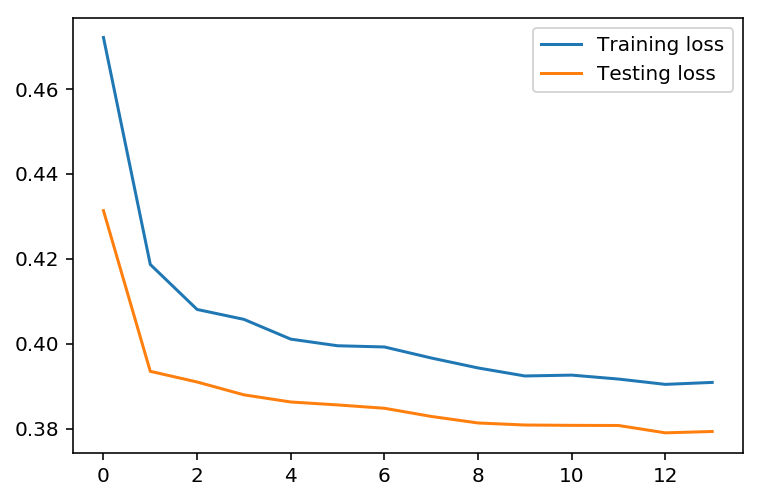

In [32]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Testing loss')
plt.legend();
print("Keras NeuralNetwork Score:", score[1])

<a id='Accuracy'></a>
## Accuracy

Keras NeuralNetwork Score: 0.8222223189142015


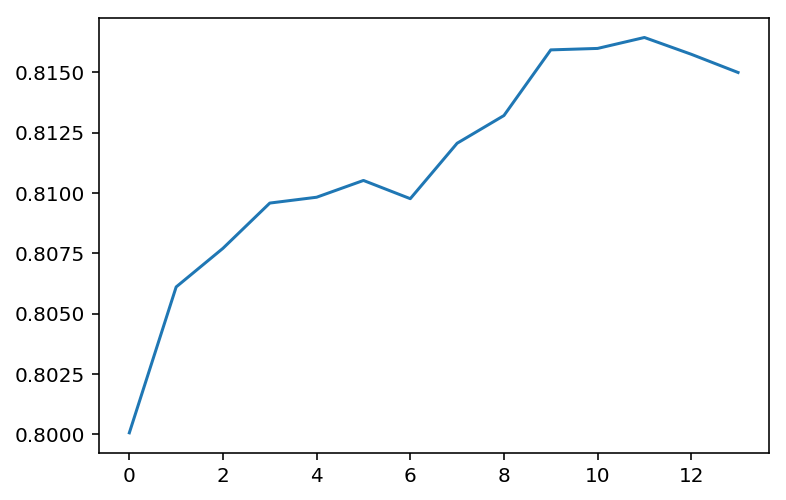

In [33]:
plt.plot(history.history['acc']);
print("Keras NeuralNetwork Score:", score[1])

<a id='Can Text Data Have Better Prediction?'></a>
## Can Text Data Have Better Prediction?
No, text data do outperformed other models such as RandomForest Classifier and Logistic Regression, it underperformed Neural Network.

In [8]:
# Function to use to check to model score
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy

In [32]:
%%time
X = amazon['review_summary']
y = amazon['rating']

X_train, X_test, y_train, y_test = train_test_split(X,y)

le = LabelEncoder()
le.fit(y)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

tfidf = TfidfVectorizer(stop_words='english',
                     ngram_range=(1, 3),
                     strip_accents='unicode')
tfidf.fit(X_train)
           
Xs_train = pd.DataFrame(tfidf.transform(X_train).todense(),columns=tfidf.get_feature_names())
Xs_test = pd.DataFrame(tfidf.transform(X_test).todense(),columns=tfidf.get_feature_names())

rf = RandomForestClassifier()
text_rf_random = RandomizedSearchCV(estimator = rf,
                                   param_distributions = random_grid,
                                   n_iter = 100,
                                   cv = 5,
                                   verbose = 1,
                                   random_state = 42,
                                   n_jobs = 1)
text_rf_random.fit(Xs_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 163.7min finished


CPU times: user 2h 39min 49s, sys: 5min 27s, total: 2h 45min 16s
Wall time: 2h 45min 19s


In [33]:
best_random = text_rf_random.best_estimator_
random_accuracy = best_random.score(Xs_test, y_test)
print('RandomForest Classifier Score:', random_accuracy * 100)

RandomForest Classifier Score: 56.39269406392694
